In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# data form spark
df = pd.read_csv('data_week.csv', header=None, names=['ts', 'ts_week', 'number', 'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng'])

In [6]:
df.shape

(8381556, 7)

In [4]:
df.dtypes

ts           object
ts_week      object
number        int64
pick_lat    float64
pick_lng    float64
drop_lat    float64
drop_lng    float64
dtype: object

In [15]:
df['ts'] = df['ts'].astype('datetime64[ns]')
df['ts_week'] = df['ts_week'].astype('datetime64[ns]')

In [17]:
df['ts_week']=df['ts_week'].dt.date

In [18]:
df.head()

,number,ts,ts_week,pick_lat,pick_lng,drop_lat,drop_lng,CohortGroup
0,14626,2018-04-07 01:37:17,2018-04-01,12.313621,76.658195,12.287301,76.602280,2018-04-01
1,85490,2018-04-07 02:02:27,2018-04-01,12.943947,77.560745,12.954014,77.543770,2018-04-01
2,5408,2018-04-07 02:06:44,2018-04-01,12.899603,77.587300,12.934780,77.569950,2018-04-01
3,58940,2018-04-07 02:08:00,2018-04-01,12.918229,77.607544,12.968971,77.636375,2018-04-01
4,5408,2018-04-07 02:09:29,2018-04-01,12.899490,77.587270,12.934780,77.569950,2018-04-01


In [19]:
df.set_index('number', inplace=True)
# create CohortGroup which picks up the rider's onboarding week
df['CohortGroup'] = df.groupby(level=0)['ts_week'].min()
df.reset_index(inplace=True)
df.head()

,number,ts,ts_week,pick_lat,pick_lng,drop_lat,drop_lng,CohortGroup
0,14626,2018-04-07 01:37:17,2018-04-01,12.313621,76.658195,12.287301,76.602280,2018-04-01
1,85490,2018-04-07 02:02:27,2018-04-01,12.943947,77.560745,12.954014,77.543770,2018-04-01
2,5408,2018-04-07 02:06:44,2018-04-01,12.899603,77.587300,12.934780,77.569950,2018-04-01
3,58940,2018-04-07 02:08:00,2018-04-01,12.918229,77.607544,12.968971,77.636375,2018-04-01
4,5408,2018-04-07 02:09:29,2018-04-01,12.899490,77.587270,12.934780,77.569950,2018-04-01


In [20]:
grouped = df.groupby(['CohortGroup', 'ts_week'])

# count the unique users per Group
cohorts = grouped.agg({'number': pd.Series.nunique})

cohorts.rename(columns={'number': 'total_rides'}, inplace=True)
cohorts.head(1000)

total_rides
CohortGroup ts_week                
2018-04-01  2018-04-01         4344
            2018-04-08         2717
            2018-04-15         2384
            2018-04-22         2209
            2018-04-29         2007
...                             ...
2018-09-09  2019-03-31          789
2018-09-16  2018-09-16         1711
            2018-09-23          496
            2018-09-30          475
            2018-10-07          406

[1000 rows x 1 columns]

In [21]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the first ride.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

# adding CohortPeriod per CohortGroup
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(1000)

total_rides  CohortPeriod
CohortGroup ts_week                              
2018-04-01  2018-04-01         4344             1
            2018-04-08         2717             2
            2018-04-15         2384             3
            2018-04-22         2209             4
            2018-04-29         2007             5
...                             ...           ...
2018-09-09  2019-03-31          789            30
2018-09-16  2018-09-16         1711             1
            2018-09-23          496             2
            2018-09-30          475             3
            2018-10-07          406             4

[1000 rows x 2 columns]

In [22]:
# reindexing the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_rides'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-04-01    4344
2018-04-08    8848
2018-04-15    4836
2018-04-22    3590
2018-04-29    2785
Name: total_rides, dtype: int64

In [26]:
user_retention=cohorts['total_rides'].unstack(0)
user_retention.T

CohortPeriod,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
CohortGroup,,,,,,,,,,,,,,,,,,,,,
2018-04-01,4344.0,2717.0,2384.0,2209.0,2007.0,1931.0,1933.0,1858.0,1868.0,1737.0,...,2253.0,2412.0,2481.0,2498.0,2534.0,2563.0,2565.0,2574.0,2502.0,2575.0
2018-04-08,8848.0,4096.0,3759.0,3117.0,2995.0,2963.0,2893.0,2915.0,2651.0,2601.0,...,4438.0,4696.0,4615.0,4693.0,4816.0,4832.0,4837.0,4770.0,4861.0,NaN
2018-04-15,4836.0,1572.0,1221.0,1147.0,1139.0,1108.0,1133.0,1003.0,1023.0,1077.0,...,2366.0,2403.0,2440.0,2479.0,2464.0,2535.0,2476.0,2520.0,NaN,NaN
2018-04-22,3590.0,969.0,835.0,828.0,778.0,741.0,673.0,701.0,716.0,710.0,...,1645.0,1727.0,1793.0,1783.0,1825.0,1749.0,1750.0,NaN,NaN,NaN
2018-04-29,2785.0,753.0,602.0,611.0,596.0,494.0,523.0,519.0,501.0,549.0,...,1338.0,1367.0,1386.0,1357.0,1335.0,1376.0,NaN,NaN,NaN,NaN
2018-05-06,2556.0,694.0,574.0,551.0,493.0,476.0,462.0,461.0,460.0,439.0,...,1241.0,1231.0,1274.0,1248.0,1241.0,NaN,NaN,NaN,NaN,NaN
2018-05-13,2504.0,664.0,550.0,484.0,472.0,497.0,495.0,480.0,448.0,423.0,...,1236.0,1235.0,1227.0,1248.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-20,2379.0,639.0,493.0,443.0,424.0,433.0,453.0,409.0,416.0,377.0,...,1160.0,1144.0,1157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-27,2317.0,540.0,463.0,428.0,405.0,438.0,378.0,381.0,374.0,395.0,...,1116.0,1132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


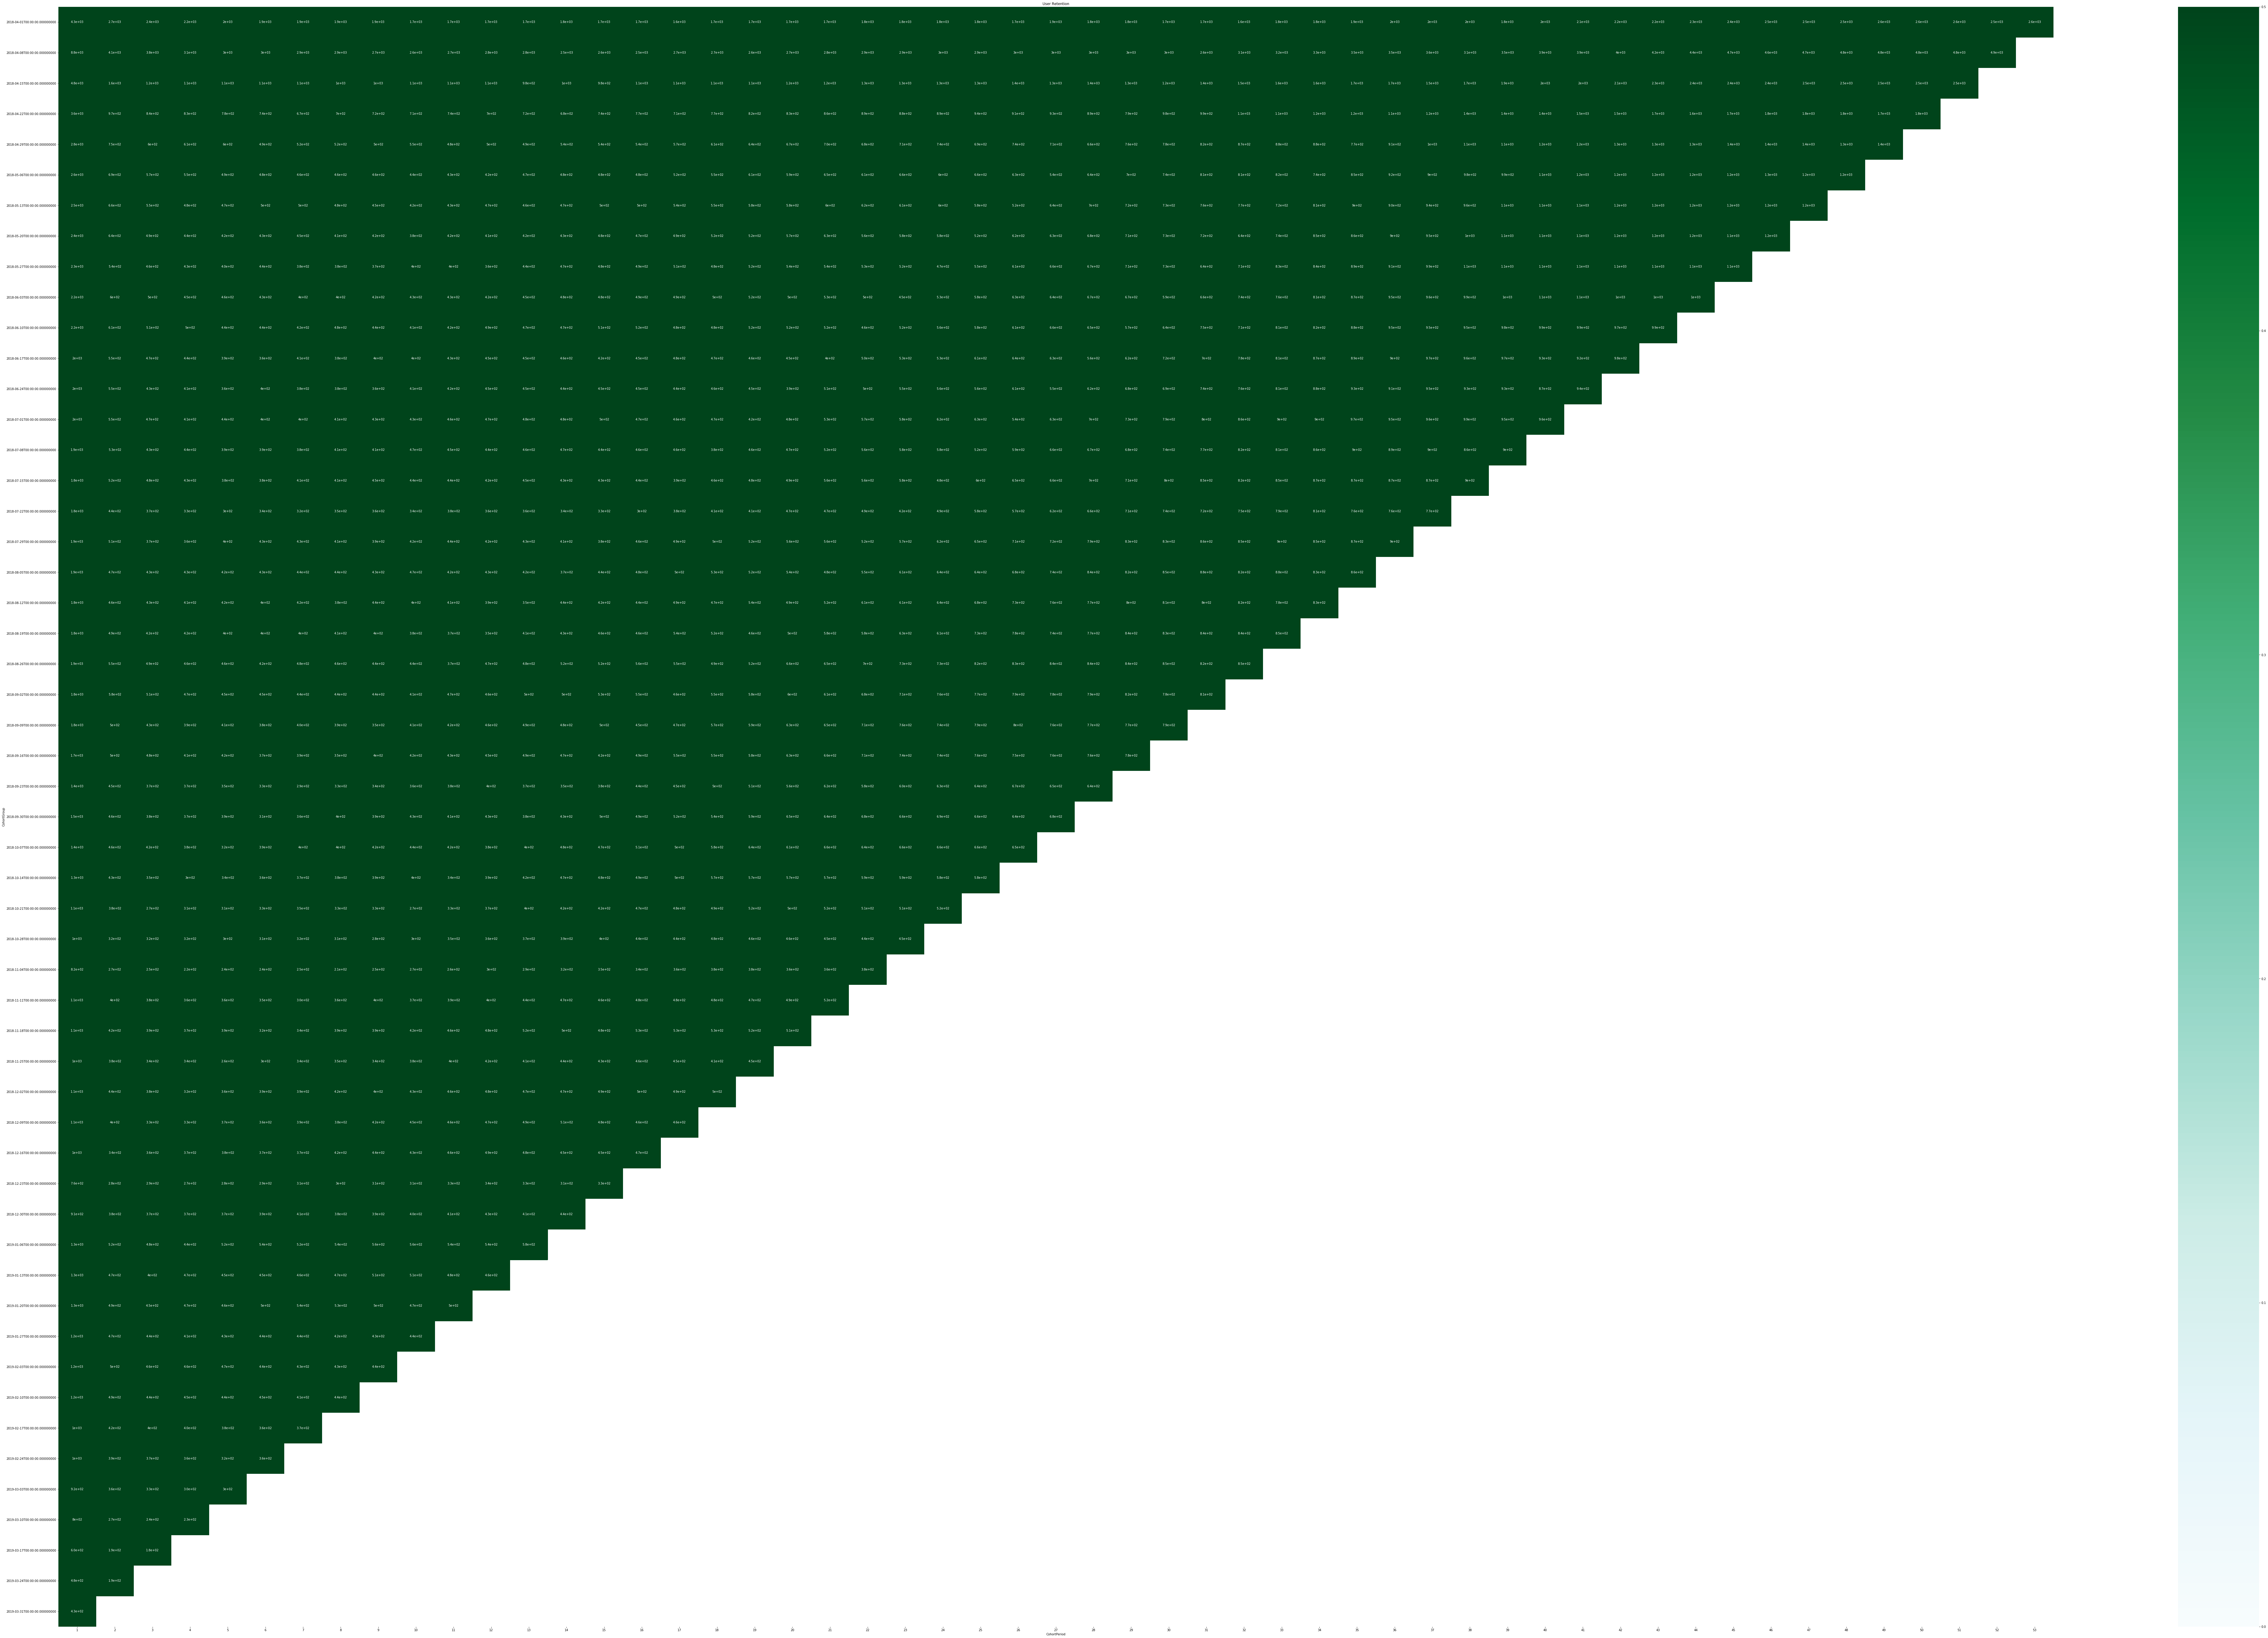

In [25]:
plt.figure(figsize=(150,100))
plt.title('User Retention')
sns.heatmap(data=user_retention.T, annot=True, vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()